In [21]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [22]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 256x256x3
        self.e11 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # output: 256x256x32
        self.e12 = nn.Conv2d(32, 32, kernel_size=3, padding=1) # output: 256x256x32
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 128x128x32

        # input: 128x128x32
        # ------- YOUR CODE HERE --------------------------------------------------------------------
        self.e21 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.e22 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x64
        self.dropout = nn.Dropout(p=0.5) # dropout 
        # input: 64x64x64
        self.e31 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.e32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x128

        # input: 32x32x128
        self.e41 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.e42 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x256

        # input: 16x16x256
        self.e51 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.e52 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512


        # -------------------------------------------------------------------------------------------------
        # Decoder
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        # ------- YOUR CODE HERE --------------------------------------------------------------------

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(32, 32, kernel_size=3, padding=1)

        # -------------------------------------------------------------------------------------------------
        # Output layer
        self.outconv = nn.Conv2d(32, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        # ------- YOUR CODE HERE --------------------------------------------------------------------
        # xp1=self.dropout(xp1)
        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)
        # xp2= self.dropout(xp2)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)
        # xp3=self.dropout(xp3)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)
        # xp4=self.dropout(xp4)
        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # -------------------------------------------------------------------------------------------------
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import random
from functools import reduce
import itertools
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from collections import defaultdict
import torch.nn.functional as F
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy


def generate_random_data(height, width, count):
    x, y = zip(*[generate_img_and_mask(height, width) for i in range(0, count)])

    X = np.asarray(x) * 255
    X = X.repeat(3, axis=1).transpose([0, 2, 3, 1]).astype(np.uint8)
    Y = np.asarray(y)

    return X, Y


def generate_img_and_mask(height, width):
    shape = (height, width)

    triangle_location = get_random_location(*shape)
    circle_location1 = get_random_location(*shape, zoom=0.7)
    circle_location2 = get_random_location(*shape, zoom=0.5)
    mesh_location = get_random_location(*shape)
    square_location = get_random_location(*shape, zoom=0.8)
    plus_location = get_random_location(*shape, zoom=1.2)

    # Create input image
    arr = np.zeros(shape, dtype=bool)
    arr = add_triangle(arr, *triangle_location)
    arr = add_circle(arr, *circle_location1)
    arr = add_circle(arr, *circle_location2, fill=True)
    arr = add_mesh_square(arr, *mesh_location)
    arr = add_filled_square(arr, *square_location)
    arr = add_plus(arr, *plus_location)
    arr = np.reshape(arr, (1, height, width)).astype(np.float32)

    # Create target masks
    masks = np.asarray([
        add_filled_square(np.zeros(shape, dtype=bool), *square_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location2, fill=True),
        add_triangle(np.zeros(shape, dtype=bool), *triangle_location),
        add_circle(np.zeros(shape, dtype=bool), *circle_location1),
         add_filled_square(np.zeros(shape, dtype=bool), *mesh_location),
        # add_mesh_square(np.zeros(shape, dtype=bool), *mesh_location),
        add_plus(np.zeros(shape, dtype=bool), *plus_location)
    ]).astype(np.float32)

    return arr, masks


def add_square(arr, x, y, size):
    s = int(size / 2)
    arr[x-s,y-s:y+s] = True
    arr[x+s,y-s:y+s] = True
    arr[x-s:x+s,y-s] = True
    arr[x-s:x+s,y+s] = True

    return arr


def add_filled_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, yy > y - s, yy < y + s]))


def logical_and(arrays):
    new_array = np.ones(arrays[0].shape, dtype=bool)
    for a in arrays:
        new_array = np.logical_and(new_array, a)

    return new_array


def add_mesh_square(arr, x, y, size):
    s = int(size / 2)

    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]

    return np.logical_or(arr, logical_and([xx > x - s, xx < x + s, xx % 2 == 1, yy > y - s, yy < y + s, yy % 2 == 1]))


def add_triangle(arr, x, y, size):
    s = int(size / 2)

    triangle = np.tril(np.ones((size, size), dtype=bool))

    arr[x-s:x-s+triangle.shape[0],y-s:y-s+triangle.shape[1]] = triangle

    return arr


def add_circle(arr, x, y, size, fill=False):
    xx, yy = np.mgrid[:arr.shape[0], :arr.shape[1]]
    circle = np.sqrt((xx - x) ** 2 + (yy - y) ** 2)
    new_arr = np.logical_or(arr, np.logical_and(circle < size, circle >= size * 0.7 if not fill else True))

    return new_arr


def add_plus(arr, x, y, size):
    s = int(size / 2)
    arr[x-1:x+1,y-s:y+s] = True
    arr[x-s:x+s,y-1:y+1] = True

    return arr


def get_random_location(width, height, zoom=1.0):
    x = int(width * random.uniform(0.1, 0.9))
    y = int(height * random.uniform(0.1, 0.9))

    size = int(min(width, height) * random.uniform(0.06, 0.12) * zoom)

    return (x, y, size)


def plot_img_array(img_array, ncol=3):
    nrow = len(img_array) // ncol

    f, plots = plt.subplots(nrow, ncol, sharex='all', sharey='all', figsize=(ncol * 4, nrow * 4))

    for i in range(len(img_array)):
        plots[i // ncol, i % ncol]
        plots[i // ncol, i % ncol].imshow(img_array[i])


def plot_side_by_side(img_arrays):
    flatten_list = reduce(lambda x,y: x+y, zip(*img_arrays))

    plot_img_array(np.array(flatten_list), ncol=len(img_arrays))


def plot_errors(results_dict, title):
    markers = itertools.cycle(('+', 'x', 'o'))

    plt.title('{}'.format(title))

    for label, result in sorted(results_dict.items()):
        plt.plot(result, marker=next(markers), label=label)
        plt.ylabel('dice_coef')
        plt.xlabel('epoch')
        plt.legend(loc=3, bbox_to_anchor=(1, 0))

    plt.show()


def masks_to_colorimg(masks):
    colors = np.asarray([(201, 58, 64), (242, 207, 1), (0, 152, 75), (101, 172, 228),(56, 34, 132), (160, 194, 56)])

    colorimg = np.ones((masks.shape[1], masks.shape[2], 3), dtype=np.float32) * 255
    channels, height, width = masks.shape

    for y in range(height):
        for x in range(width):
            selected_colors = colors[masks[:,y,x] > 0.5]

            if len(selected_colors) > 0:
                colorimg[y,x,:] = np.mean(selected_colors, axis=0)

    return colorimg.astype(np.uint8)


def generate_images_and_masks_then_plot():
    # Generate some random images
    # ------- YOUR CAN MODIFY HERE --------------------------------------------------------------------
    input_images, target_masks = generate_random_data(192, 192, count=3)
    # -------------------------------------------------------------------------------------------------

    for x in [input_images, target_masks]:
        print(x.shape)
        print(x.min(), x.max())

    # Change channel-order and make 3 channels for matplot
    input_images_rgb = [x.astype(np.uint8) for x in input_images]

    # Map each channel (i.e. class) to each color
    target_masks_rgb = [masks_to_colorimg(x) for x in target_masks]

    # Left: Input image (black and white), Right: Target mask (6ch)
    plot_side_by_side([input_images_rgb, target_masks_rgb])


def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp


class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        # ------- YOUR CAN MODIFY HERE --------------------------------------------------------------------
        self.input_images, self.target_masks = generate_random_data(192, 192, count=count)
        # -------------------------------------------------------------------------------------------------
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)

        return [image, mask]


def get_data_loaders():
    # use the same transformations for train/val in this example
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
    ])

    train_set = SimDataset(700, transform = trans)
    val_set = SimDataset(20, transform = trans)

    image_datasets = {
        'train': train_set, 'val': val_set
    }

    batch_size = 128

    dataloaders = {
        'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=18),
        'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=18)
    }

    return dataloaders


def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()


def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


def train_model(model, optimizer, scheduler, num_epochs=25):
    dataloaders = get_data_loaders()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
            
                # statistics
                epoch_samples += inputs.size(0)
                
            
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                
        scheduler.step()
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def run(UNet):
    num_class = 6
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if torch.cuda.is_available():
        print('use GPU !')

    model = UNet(num_class).to(device)
    # ------- YOUR CAN MODIFY HERE --------------------------------------------------------------------
    # print('model structure is below:')
    # print(model)
    optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

    # scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=300, gamma=0.1)
    scheduler=lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=200,eta_min=1e-6) # I replaced the StepLR with CosineAnnealingLR, which work better

    model = train_model(model, optimizer_ft, scheduler, num_epochs=80)
    # -------------------------------------------------------------------------------------------------
    model.eval()  # Set model to the evaluation mode

    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # imagenet
    ])
    # # Create another simulation dataset for test
    test_dataset = SimDataset(3, transform = trans)
    test_loader = DataLoader(test_dataset, batch_size=9999, shuffle=False, num_workers=18)

    # Get the first batch
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Predict
    pred = model(inputs)
    # The loss functions include the sigmoid function.
    pred = F.sigmoid(pred)
    pred = pred.data.cpu().numpy()
    print(pred.shape)

    # Change channel-order and make 3 channels for matplot
    input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

    # Map each channel (i.e. class) to each color
    target_masks_rgb = [masks_to_colorimg(x) for x in labels.cpu().numpy()]
    pred_rgb = [masks_to_colorimg(x) for x in pred]

    plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])

(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0


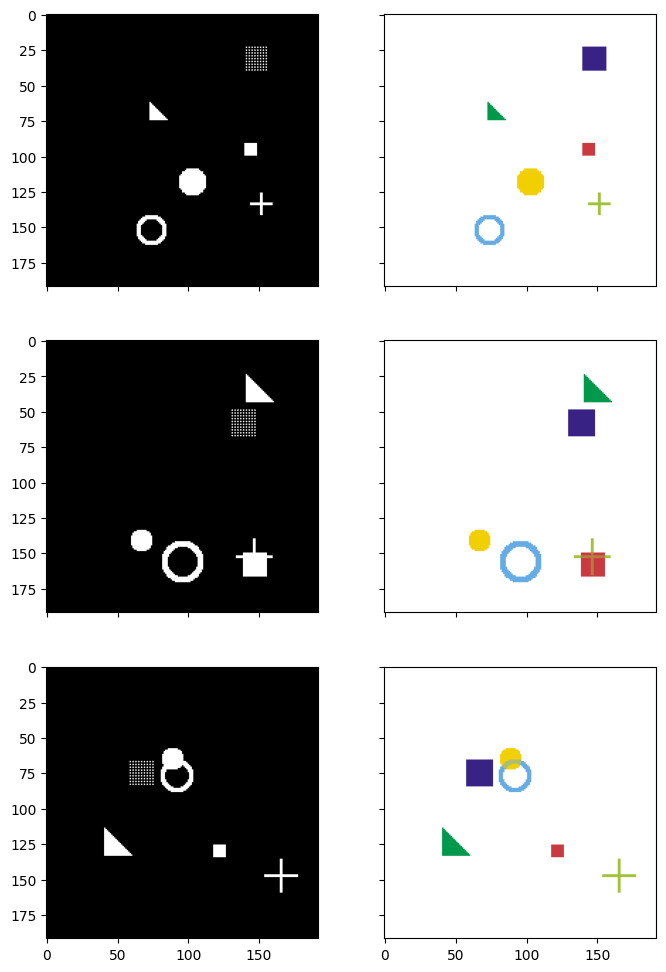

In [24]:
generate_images_and_masks_then_plot()

use GPU !
Epoch 0/79
----------
LR 0.001
train: bce: 0.608040, dice: 0.990905, loss: 0.799473
val: bce: 0.160926, dice: 0.993726, loss: 0.577326
saving best model
0m 4s
Epoch 1/79
----------
LR 0.0009999383779245895
train: bce: 0.105706, dice: 0.987712, loss: 0.546709
val: bce: 0.026207, dice: 0.941376, loss: 0.483791
saving best model
0m 4s
Epoch 2/79
----------
LR 0.000999753526902683
train: bce: 0.020204, dice: 0.884182, loss: 0.452193
val: bce: 0.017998, dice: 0.827321, loss: 0.422659
saving best model
0m 4s
Epoch 3/79
----------
LR 0.0009994454925435043
train: bce: 0.017624, dice: 0.808829, loss: 0.413227
val: bce: 0.018236, dice: 0.796354, loss: 0.407295
saving best model
0m 4s
Epoch 4/79
----------
LR 0.000999014350849922
train: bce: 0.017539, dice: 0.781995, loss: 0.399767
val: bce: 0.018043, dice: 0.769384, loss: 0.393714
saving best model
0m 4s
Epoch 5/79
----------
LR 0.0009984602081996978
train: bce: 0.018553, dice: 0.760280, loss: 0.389416
val: bce: 0.017837, dice: 0.74368

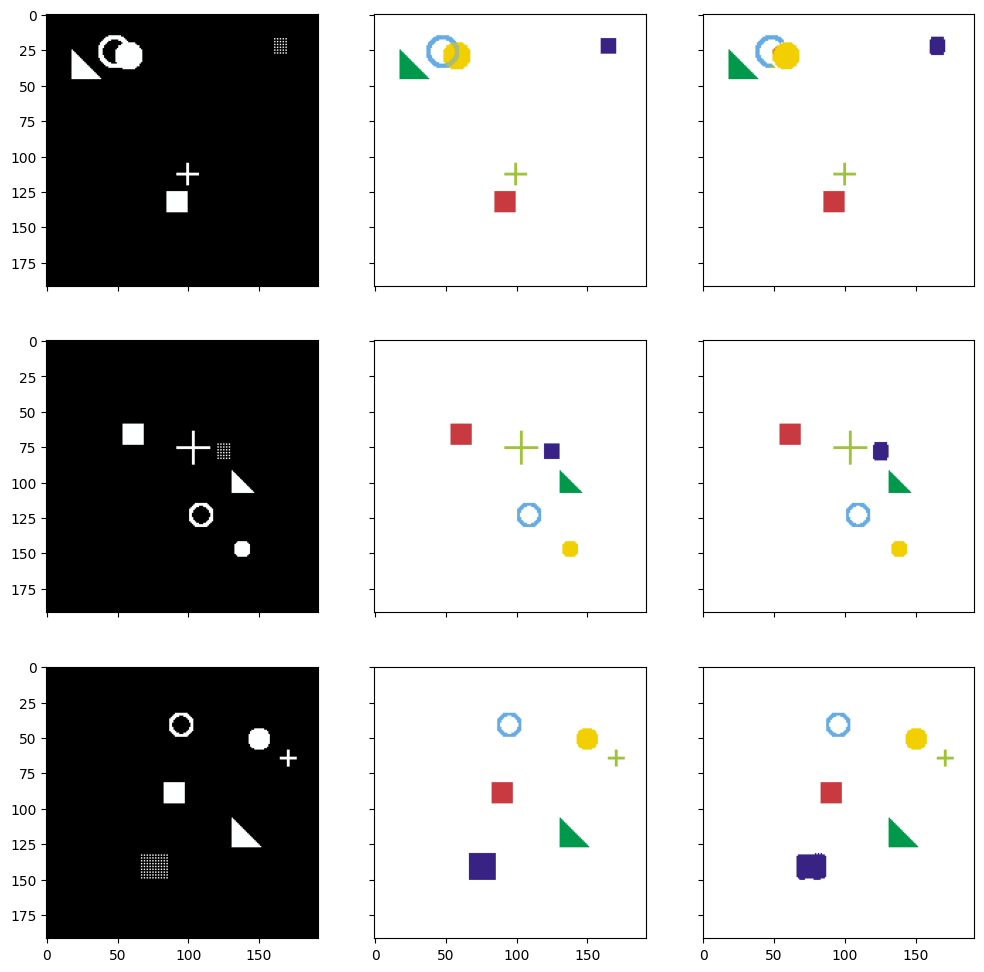

In [25]:
run(UNet)